# Reconstruction of systems of 1st order linear DEs by multiple time series

The method of choice is the analysis givven in [1,2] for time series' in a high dimensional space. First we explain the 1D approach by means of a Principle Component Analysis.

The basic principle is best explained in a 1D system. Given a time series $x(t)$ we are looking for a DE $\dot y(t)=f(y)$ which by integration reproduces the time series $x(t)$. To this end we minimize the mean square deviation
$$ W=\langle (\dot x(t)-f(x(t))^2\rangle $$
where
$$ \langle W(t)\rangle = \frac{1}{t_1-t_0}\int\limits_{t_0}^{t_1} W(t)dt $$
For $f(x(t))$ we make an ansatz $f(x(t))=\sum_i a_i\phi_i(x(t))$. Minimizing $W(t)$ gives the $a_i$ by $\frac{\partial W}{\partial a_i}=0$ to yield
$$ a_i=\langle \dot x\phi_j(x)\rangle D^{-1}_{ji}\mbox{ where } D_{ij}=\langle \phi_i(x)\phi_j(x)\rangle $$

For high dimensional Systems we introduce the coupling of the time series'. Given a high dimensional signal $\mathbf{x}(t)$ we want to find the corresponding equation of motion. In this case we have for the component $i$ of the vector $\mathbf{f}$
$$ f_i(\mathbf{x}) = a^{ij}x_j+a^{ijk}x_jx_k\dots$$


[1]  K. Karhunen, "Zur Spektraltheorie stochastischer Prozesse," Ann. Acad. Sci. Fenn. A1, Math. Phys. 37 (1946)

[2] C. Uhl, Analyse raumzeitlicher Daten strukturbildender Systeme, Verlag Shaker (1995)

Still to be found: M. Loeve, “Fonctions aleatoires de second ordre,” Comptes Rendus De L'Académie Des Sciences, vol. 220, (1945).

### Load the respective libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

### Get the data

In [2]:
numbered=np.load('Numbered.npy').item()
#
npzfile=np.load('CDR_Data.npz')
yC=npzfile['yC']
yD=npzfile['yD']
yR=npzfile['yR']
#
# The following should be the same for all three and is for plotting
countries=yC.shape[0]
x=np.arange(yC.shape[1])

#### In case we want to check what we read we define plotting functions for the data retrieved, linear plot and log plot

In [ ]:
def plotcountry(y,Country,istart,title):
    fig, ax = plt.subplots()
    for c in Country: 
        i=numbered[c]
        ax.plot(x[istart:],y[i,istart:],label=c)
    legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.title(title)
    plt.xlabel('time [day]')
    plt.ylabel('Number of cases')
    plt.show()

### Plot choices of data

In [ ]:
%matplotlib notebook
plotcountry(yC,['US','Germany','France'],0,'Confirmed')
plt.savefig('Cases.png')

# 1D System

We define $\phi_i(x)$ and calculate $D_{ij}=\langle \phi_i(x)\phi_j(x)\rangle$ as well as its inverse $D_{ij}^{-1}$

In [5]:
# Monomials
def phi(i,x):
    return x**i
# Matrix D
def CalculateDij(n):
    Dij=np.zeros((n,n))
    for i in np.arange(n):
        for j in np.arange(i):
            Dij[i,j]=np.einsum('i,i',phi(i,x),phi(j,x))/len(x)
            Dij[j,i]=Dij[i,j]
        Dij[i,i]=np.einsum('i,i',phi(i,x),phi(i,x))/len(x)
    return np.linalg.inv(Dij)
# Define r.h.s. of DE
def f(t,y):
    return np.sum([ai[i]*phi(i,y) for i in np.arange(4)],axis=0)

In [7]:
country='Germany'
xoft=yC[numbered[country]]
# b=np.asarray(np.where(xoft<1))
# xoft=np.delete(xoft,np.arange(b[0,-1]+1))
# x=np.delete(x,np.arange(b[0,-1]+1))
InvDij=CalculateDij(4)
xdot=np.gradient(xoft,edge_order=2)
A=[np.einsum('i,i',xdot,phi(i,xoft))/len(xoft) for i in np.arange(4)]
ai=np.einsum('j,ji->i',A,InvDij)

In [32]:
#
b=np.asarray(np.where(yC[60]<1))
t0=np.reshape(b,(b.shape[1]))[-1]
y0=1.0
sol=solve_ivp(func,[0.,len(x)],[0.0],method='RK45',dense_output=True)

In [ ]:
%matplotlib notebook
plt.plot(x,f(1,x))

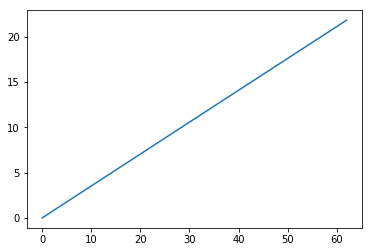

In [33]:
plt.plot(func(1,x))

In [30]:
# Define the model function $e^{a\cdot (x-x_0)}$
def fit(x,a0,a1,a2,a3):
    return a0+a1*x+a2*x**2+a3*x**3
# Fit to the model
country='Germany'
xoft=yC[numbered[country]]
xdot=np.gradient(xoft,edge_order=2)
#
bounds=([0,-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf])
popt,pcov = curve_fit(fit,xoft,xdot,p0=None,absolute_sigma=False,check_finite=True,bounds=bounds)
popt

array([ 2.03342708e-20,  3.52466829e-01, -1.25536330e-05,  1.64056202e-10])

In [19]:
fit(xoft,popt[0],popt[1],popt[2],popt[3])

array([-1.91870883e+01, -1.91870883e+01, -1.91870883e+01, -1.91870883e+01,
       -1.91870883e+01, -1.88284011e+01, -1.77524954e+01, -1.77524954e+01,
       -1.77524954e+01, -1.73939120e+01, -1.63183176e+01, -1.56013844e+01,
       -1.48845550e+01, -1.48845550e+01, -1.48845550e+01, -1.48845550e+01,
       -1.45261792e+01, -1.45261792e+01, -1.41678294e+01, -1.41678294e+01,
       -1.34512075e+01, -1.34512075e+01, -1.34512075e+01, -1.34512075e+01,
       -1.34512075e+01, -1.34512075e+01, -1.34512075e+01, -1.34512075e+01,
       -1.34512075e+01, -1.34512075e+01, -1.34512075e+01, -1.34512075e+01,
       -1.34512075e+01, -1.34512075e+01, -1.30929354e+01, -9.51164126e+00,
       -2.71432395e+00, -1.99936101e+00,  9.06931991e+00,  2.72250017e+01,
        3.75188618e+01,  5.06209220e+01,  7.39046702e+01,  1.50710839e+02,
        2.15368481e+02,  2.59217686e+02,  3.40018840e+02,  3.84977399e+02,
        4.76423115e+02,  6.19165481e+02,  6.71699610e+02,  1.13230772e+03,
        1.36921914e+03,  

In [31]:
def func(t,x):
    return popt[0]+popt[1]*x+popt[2]*x**2+popt[3]*x**3

In [24]:
np.where(xoft<1)

(array([0, 1, 2, 3, 4]),)

In [28]:
b=np.asarray(np.where(xoft<1))

In [35]:
np.delete(xoft,b)

array([1.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00, 5.0000e+00,
       8.0000e+00, 1.0000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01,
       1.2000e+01, 1.3000e+01, 1.3000e+01, 1.4000e+01, 1.4000e+01,
       1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01,
       1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01,
       1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01, 1.7000e+01,
       2.7000e+01, 4.6000e+01, 4.8000e+01, 7.9000e+01, 1.3000e+02,
       1.5900e+02, 1.9600e+02, 2.6200e+02, 4.8200e+02, 6.7000e+02,
       7.9900e+02, 1.0400e+03, 1.1760e+03, 1.4570e+03, 1.9080e+03,
       2.0780e+03, 3.6750e+03, 4.5850e+03, 5.7950e+03, 7.2720e+03,
       9.2570e+03, 1.2327e+04, 1.5320e+04, 1.9848e+04, 2.2213e+04,
       2.4873e+04, 2.9056e+04, 3.2986e+04])

In [34]:
xoft

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00, 5.0000e+00,
       8.0000e+00, 1.0000e+01, 1.2000e+01, 1.2000e+01, 1.2000e+01,
       1.2000e+01, 1.3000e+01, 1.3000e+01, 1.4000e+01, 1.4000e+01,
       1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01,
       1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01,
       1.6000e+01, 1.6000e+01, 1.6000e+01, 1.6000e+01, 1.7000e+01,
       2.7000e+01, 4.6000e+01, 4.8000e+01, 7.9000e+01, 1.3000e+02,
       1.5900e+02, 1.9600e+02, 2.6200e+02, 4.8200e+02, 6.7000e+02,
       7.9900e+02, 1.0400e+03, 1.1760e+03, 1.4570e+03, 1.9080e+03,
       2.0780e+03, 3.6750e+03, 4.5850e+03, 5.7950e+03, 7.2720e+03,
       9.2570e+03, 1.2327e+04, 1.5320e+04, 1.9848e+04, 2.2213e+04,
       2.4873e+04, 2.9056e+04, 3.2986e+04])

NameError: name 'x' is not defined